In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
from copy import deepcopy
import os
import linecache
import sys
import matplotlib as mpl
import scipy.optimize
import datetime
import pandas as pd

from time import time as time

from numba import jit, njit, vectorize, cuda,guvectorize



mpl.rcParams['figure.facecolor'] = 'w'


mpl.rcParams["image.origin"] = 'lower'

ModuleNotFoundError: No module named 'numba'

In [ ]:
mass =  133*1.66053906660E-27 # mass of Rb?
hbar = 6.62607004E-34/(2*np.pi)
wavelength = 2*0.532E-6
E_R = 2*np.pi*hbar/(2*mass*wavelength*wavelength)

In [3]:
from colorsys import hls_to_rgb

def colorize(z,vmax = None):
    r = np.abs(z)
    if vmax == None:
      vmax = np.max(r)*1.2
    r = r/vmax
    arg = np.angle(z) 

    h = (arg + np.pi)  / (2 *np.pi) + 0.5#h是什么含义？
    l = r
    s = 1

    c = np.vectorize(hls_to_rgb) (h,l,s) # --> tuple
    c = np.array(c)  # -->  array of (3,n,m) shape, but need (n,m,3)
    c = c.swapaxes(0,2) 
    c = c.swapaxes(1,0)
    return c

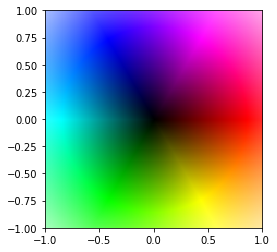

In [4]:
x_tmp,y_tmp = np.meshgrid(np.arange(-1,1,0.01),np.arange(-1,1,0.01))
z_tmp = x_tmp + 1j*y_tmp
plt.figure()
plt.imshow(colorize(z_tmp),extent = (-1,1,-1,1))
plt.show()

# GPE

## GPU ver

In [8]:

# !pip install cupy
import cupy as cp

ImportError: CuPy is not correctly installed.

If you are using wheel distribution (cupy-cudaXX), make sure that the version of CuPy you installed matches with the version of CUDA on your host.
Also, confirm that only one CuPy package is installed:
  $ pip freeze

If you are building CuPy from source, please check your environment, uninstall CuPy and reinstall it with:
  $ pip install cupy --no-cache-dir -vvvv

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

original error: DLL load failed: 找不到指定的模块。

In [6]:
xstep = 532E-9

In [7]:
class new_grid:
  
  
  def __init__(self,N,L):
    
    
    kgrid = lambda N, Lmax: cp.arange(-N/2,N/2,1)*np.pi/Lmax
    rgrid = lambda N, Lmax: cp.arange(-N/2,N/2,1)*2/N*Lmax
    
    if np.size(N)<2:
        N = [N,N]
    
    if np.size(L)<2:
        L = [L,L]
    
    Nx, Ny = N
    Lx, Ly = L
    
    [kx,ky] = cp.meshgrid(kgrid(Nx,Lx),kgrid(Ny,Ly),indexing='ij')
    [x,y] = cp.meshgrid(rgrid(Nx,Lx),rgrid(Ny,Ly),indexing='ij')


    ksq = kx**2+ky**2
    rsq = x**2+y**2
    
    self.x=x
    self.y=y
    self.kx=kx
    self.kxs = cp.fft.ifftshift(kx)
    self.ky=ky
    self.kys = cp.fft.ifftshift(ky)
    self.ksq=ksq
    self.ksqs = cp.fft.ifftshift(ksq)
    self.rsq=rsq
    self.dim=2
    self.Nx = Nx
    self.Ny = Ny
    self.Lx = Lx
    self.Ly = Ly
    self.dx = 2*Lx/Nx
    self.dy = 2*Ly/Ny
    
    self.flatten = lambda x: cp.reshape(x,(Nx*Ny,))
    self.unflatten = lambda x: cp.reshape(x,(Nx,Ny))
    
    boundary_mask = cp.zeros(self.x.shape,dtype=bool)
    boundary_mask[x == cp.min(x)] = 1
    boundary_mask[x == cp.max(x)] = 1
    boundary_mask[y == cp.min(y)] = 1
    boundary_mask[y == cp.max(y)] = 1
    
    self.boundary_mask = boundary_mask
#    Mxp = scipy.sparse.csc_matrix((Nx*Ny,Nx*Ny))
#    Mxm = scipy.sparse.csc_matrix((Nx*Ny,Nx*Ny))
#    Myp = scipy.sparse.csc_matrix((Nx*Ny,Nx*Ny))
#    Mym = scipy.sparse.csc_matrix((Nx*Ny,Nx*Ny))
#    for ix in np.arange(Nx):
#      for iy in np.arange(Ny):
#        vec = np.zeros((Nx,Ny))
#        vec[ix,iy] = 1
#        vecxp = np.roll(vec,-1,axis=0)
#        vecxm = np.roll(vec,1,axis=0)
#        vecyp = np.roll(vec,-1,axis=1)
#        vecym = np.roll(vec,1,axis=1)

#         vecf = self.flatten(vec)
#         vecxpf = self.flatten(vecxp)
#         vecypf = self.flatten(vecyp)
#         vecxmf = self.flatten(vecxm)
#         vecymf = self.flatten(vecym)
#         Mxp = Mxp + scipy.sparse.csc_matrix(np.outer(vecxpf,vecf))
#         Mxm = Mxm + scipy.sparse.csc_matrix(np.outer(vecxmf,vecf))
#         Myp = Myp + scipy.sparse.csc_matrix(np.outer(vecypf,vecf))
#         Mym = Mym + scipy.sparse.csc_matrix(np.outer(vecymf,vecf))
    
    

#     Mxp = scipy.sparse.diags((np.ones(((Nx-1)*Ny,)),np.ones((Ny,))),(Ny,-(Nx-1)*Ny))
#     Mxm = scipy.sparse.diags((np.ones(((Nx-1)*Ny,)),np.ones((Ny,))),(-Ny,(Nx-1)*Ny))
#     Mxp = scipy.sparse.csc_matrix(Mxp)
#     Mxm = scipy.sparse.csc_matrix(Mxm)
    
#     Id = scipy.sparse.identity(Nx*Ny)
    
#     Mym_block = scipy.sparse.diags((np.ones((Ny-1,)),1),(-1,Ny-1))
#     Mym = scipy.sparse.block_diag(tuple(Mym_block for ii in range(Nx)),format='csc')
#     Myp_block = scipy.sparse.diags((np.ones((Ny-1,)),1),(1,-Ny+1))
#     Myp = scipy.sparse.block_diag(tuple(Myp_block for ii in range(Nx)),format='csc')
    
#     self.Mxp = Mxp
#     self.Mxm = Mxm
#     self.Myp = Myp
#     self.Mym = Mym
#     self.Mdx = Mxp - Id
#     self.Mdy = Myp - Id
    
#     self.xp = lambda psi: np.roll(psi,-1,axis = 0)
#     self.xm = lambda psi: np.roll(psi,1,axis = 0)
#     self.yp = lambda psi: np.roll(psi,-1,axis = 1)
#     self.ym = lambda psi: np.roll(psi,1,axis = 1)
    
#     x = pyfftw.empty_aligned((Nx,Ny), dtype='complex64')
#     y = pyfftw.empty_aligned((Nx,Ny), dtype='complex64')

#     fft_obj = pyfftw.FFTW(x,y,axes = (0,1))
#     ifft_obj = pyfftw.FFTW(x,y,axes = (0,1),direction='FFTW_BACKWARD')
    
#     self.fft = fft_obj
#     self.ifft = ifft_obj
    
    
#     self.delx = lambda psi: (self.xp(psi) - psi)/self.dx
#     self.dely = lambda psi: (self.yp(psi) - psi)/self.dy
#     self.del2 = lambda psi: (self.xp(psi) + self.xm(psi)  - 2*psi )/self.dx**2 + (self.yp(psi)  + self.ym(psi) - 2*psi)/self.dy**2
#     self.del4 = lambda psi: self.del2(self.del2(psi))
  def normalize(self,psi):
    psi = psi / cp.sqrt(cp.sum(cp.abs(psi)**2*self.dx*self.dy))
    return psi
  def normalize_dens(self,psi): #normalize mean density, why need this step?
    psi = psi * cp.sqrt(cp.sum(cp.abs(psi)**2))/cp.sqrt(cp.sum(cp.abs(psi)**4))
    return psi
  def delx(self,psi,dt=None):#in k space
    psi_fft = cp.fft.fft2(psi)
    if dt == None:
      psi_fft = 1j*self.kxs*psi_fft
    else:
      psi_fft = np.exp(1j*self.kxs*dt)*psi_fft
    psi = cp.fft.ifft2(psi_fft)
    return psi

  def dely(self,psi,dt=None):
    psi_fft = cp.fft.fft2(psi)
    if dt == None:
      psi_fft = 1j*self.kys*psi_fft
    else:
      psi_fft = np.exp(1j*self.kys*dt)*psi_fft
    psi = cp.fft.ifft2(psi_fft)
    return psi
  
#   def del2(self,psi,dt=None):
#     psi_fft = np.fft.fftshift(np.fft.fft2(psi))
#     if dt == None:
#       psi_fft = -self.ksq*psi_fft
#     else:
#       psi_fft = np.exp(-dt*self.ksq)*psi_fft
#     psi = np.fft.ifft2(np.fft.ifftshift(psi_fft))
#     return psi
  
#   def del4(self,psi,dt=None):
#     psi_fft = np.fft.fftshift(np.fft.fft2(psi))
#     if dt==None:
#       psi_fft = self.ksq**2*psi_fft
#     else:
#       psi_fft = np.exp(dt*self.ksq**2)*psi_fft
#     psi = np.fft.ifft2(np.fft.ifftshift(psi_fft))
#     return psi
  
#   def special1(self,psi,params,dt=None):
#     keys = ['B','k0']
#     B,k0 = [params[key] for key in keys]
    
#     if B < 4*k0**2:
#       B = 4*k0**2
#       print('Barrier height set to minimum requirement %.4E' % B)
    
#     A = (B-2*k0**2+np.sqrt(B**2-4*B*k0**2))/(2*k0**4)
    
#     f = lambda x: x+B/(1+A*x)
    
#     psi_fft = np.fft.fftshift(np.fft.fft2(psi))
#     if dt == None:
#       psi_fft = (f(self.kx**2)-f(k0**2)+self.ksq)*psi_fft
#     else:
#       psi_fft = np.exp(dt*(f(self.kx**2)-f(k0**2)+self.ksq))*psi_fft
#     psi = np.fft.ifft2(np.fft.ifftshift(psi_fft))
    
#     return psi

def Unit_Hz(x,Lunit = xstep): #converts energy scales to Hz given unit of L
  return x*E_R/(2*np.pi*Lunit/wavelength)**2

def Unit_Esim(x,Lunit = xstep): #converts energy scales from Hz to sim unit given unit of L
  return x/(E_R/(2*np.pi*Lunit/wavelength)**2)

def Unit_m(x,Lunit = xstep): #converts length scales to m given unit of L
  return x*Lunit

def Unit_Lsim(x,Lunit = xstep): #converts length scales from m to sim unit given unit of L
  return x/Lunit

class new_simparams:
  def __init__(self,boundary = 0,boundary_mask = None,U=None,Uparams=None,dt=1,Nt=1,normalize=True,dim=2,N=16,L=10,T=[0],trapsize=1/3,trapfunc=None,trapparams=None,eta=0,e=np.array([1,0]),dispersion_type = [0]):
    grid = new_grid(N,L)
    self.grid = grid
    if boundary_mask is None:# why it is periodic?
        boundary_mask = self.grid.boundary_mask
    if type(boundary) == int:
        if boundary == 1: #1 is closed; 0 is open
            boundary = cp.zeros(self.grid.x.shape)
        elif boundary != 0:
            raise ValueError('Warning: boundary condition not understood. Input 1 for open, 0 for closed, or an array with compatible shape')
    else:
        try:
            boundary = cp.array(boundary)
        except:
            raise ValueError('Warning: boundary condition not understood. Input 1 for open, 0 for closed, or an array with compatible shape')
        if boundary.shape != self.grid.x.shape:
            raise ValueError('Warning: boundary condition not understood. Input 1 for open, 0 for closed, or an array with compatible shape')
    if boundary is not 0:
        try:
            if boundary_mask.shape != boundary.shape:
                raise ValueError('Boundary mask shape incompatible with boundary condition')
        except:
            raise ValueError('Boundary mask shape incompatible with boundary condition')
            
    self.boundary = boundary
    self.boundary_mask = boundary_mask
    self.U=U
    self.dt=dt
    self.Nt=Nt
    self.normalize=normalize
    self.dim=dim
    self.eta=eta
    self.e=e
    self.trapsize=trapsize
    if len(T)!=Nt and np.real(dt)==0:
      self.T=np.arange(0,np.abs(dt)*Nt,np.abs(dt))
    else:
      self.T=T  
    if hasattr(U, "__len__"): #U is array
      self.U=U
    else: #U is scalar
      self.U = U*np.ones_like(T)
    if trapfunc != None:
      
      self.potential = lambda t: cp.array(trapfunc(cp.asnumpy(grid.x),cp.asnumpy(grid.y),t,*trapparams))
    else:
      self.potential = lambda t: cp.zeros(grid.x.shape)#为什么是x.shape?这是方形势阱的情形？
    self.dispersion_type = dispersion_type
    
    
    
  def kinetic(self,psi,dt = None):
    psi_fft = cp.fft.fft2(psi)
    
    H = self.grid.ksqs
        
      
    if dt == None:
      psi_fft = H*psi_fft
    else:
      psi_fft = cp.exp(dt*H)*psi_fft
    psi = cp.fft.ifft2(psi_fft)
    
    return psi
  
  def gauge(self,psi):
    grid = self.grid
    psi_fft = cp.fft.fft2(psi)
    psi_fft = (self.e[0]*grid.kxs+self.e[1]*grid.kys)*psi_fft
    H = cp.conj(psi)*cp.fft.ifft2(psi_fft)
    
    return H
  
class new_hamiltonian:
  def __init__(self,simparams):
    self.simparams=simparams
  
  def act(self,psiobj,nt=0):
    if type(psiobj) == new_psi:
      psi = psiobj.value
    else:
      psi = psiobj
    n = cp.square(cp.abs(psi))
    simparams = self.simparams
    T = simparams.T
    potential=self.simparams.potential(T[nt])
    try:
      U = simparams.U[nt]
    except:
      U = simparams.U
    if False:#open boundary condition?
      None
    
    
    out = simparams.kinetic(psi)
    out = out + self.simparams.eta*simparams.gauge(psi)*psi
    out = out + potential*psi
    out = out + U*n*psi
    
    return out
  
  
  def evolve(self,psiobj,nt=0):
    if type(psiobj) == new_psi:
      psi = psiobj.value
    else:
      psi = psiobj
    
    simparams = self.simparams
    n = cp.square(cp.abs(psi))
    dt = self.simparams.dt
    T = self.simparams.T
    potential=self.simparams.potential(T[nt])
    eta = self.simparams.eta
    
    try:
      U = simparams.U[nt]
    except:
      U = simparams.U
    
    
#     Hpsi = self.act(psi,nt)
    
#     change = np.sum(np.conj(psi)*Hpsi)/np.sum(np.conj(psi)*psi)
    
#     if change*np.abs(dt)>1e-2:
#       dt = 1e-2/change*np.exp(1j*np.angle(dt))
    psi = simparams.kinetic(psi,dt)
    psi = simparams.grid.normalize(psi)
    psi = cp.exp(dt*(potential+U*n))*psi
    psi = simparams.grid.normalize(psi)
    
    return psi,dt
    
  def expectation(self,psiobj,nt=0):
    return self.energy(psiobj,nt)

  
  def energy(self,psiobj,nt=0,comp = False):
    if type(psiobj) == new_psi:
      psi = psiobj.value
    else:
      psi = psiobj
    n = cp.square(cp.abs(psi))
    simparams = self.simparams
    
    
    try:
      U = simparams.U[nt]
    except:
      U = simparams.U
   
    grid = self.simparams.grid
    T = self.simparams.T
    potential=self.simparams.potential(T[nt])
    
    if False:#open boundary condition?
      None
    
    
    inte = cp.sum(0.5*U*n**2)#interaction
    kin = cp.sum(cp.conj(psi)*simparams.kinetic(psi))#kinetic energy
    gauge = 0.5*self.simparams.eta*cp.sum(cp.conj(psi)*simparams.gauge(psi)*psi)
    pot = cp.sum(cp.conj(psi)*potential*psi)#potential
    
    inte,kin,gauge,pot = [cp.real(arr/cp.sum(cp.conj(psi)*psi)) for arr in [inte,kin,gauge,pot]]
    
    H = inte + kin + gauge+ pot
    
    
    if comp:
      return {'tot':H,'int':inte,'kin':kin,'gauge':gauge,'pot':pot}
    else:
      return H
  
  def chempot(self,psiobj,nt=0):
    if type(psiobj) == new_psi:
      psi = psiobj.value
    else:
      psi = psiobj
    n = cp.square(cp.abs(psi))
    simparams = self.simparams
  
    try:
      U = simparams.U[nt]
    except:
      U = simparams.U

    grid = self.simparams.grid
    T = self.simparams.T
    potential=self.simparams.potential(T[nt])
    
    if False:#open boundary condition?
      None
    

    Hpsi = self.act(psi,nt)
    
    mu = cp.sum(cp.conj(psi)*Hpsi)
    
    mu = cp.real(mu/cp.sum(cp.conj(psi)*psi))
    
    
    return mu
    
class new_psi:
  def __init__(self,value=[]):
    self.value = cp.array(value)
    
  def copy(self):
    out = new_psi()
    out.value = self.value
    out.grid = self.grid
    return out

  def init_random(self,grid):
    self.grid = grid
    self.value = cp.random.rand(*grid.rsq.shape) + 1j*cp.random.rand(*grid.rsq.shape) - 0.5*(1+1j)
    self.normalize()
    
  def abs2(self):
    return cp.square(cp.abs(self.value))
    
  def normalize(self,factor = 1): #factor allows for normalization of mean density
    if self.grid is not None:
      self.value = self.grid.normalize(self.value)*factor
    else: 
      self.value = self.value / cp.sqrt(cp.sum(self.abs2()))*factor

  def normalize_dens(self):
    if self.grid is not None:
      self.value = self.grid.normalize_dens(self.value)
    else: 
      self.value = self.value / cp.sqrt(cp.sum(self.abs2()))

  def kspace(self):
    return cp.fft.fftshift(cp.fft.fft2(psi.value))
  
  def dot(self,psi):
    if type(psi) == new_psi:
      out = cp.sum(cp.conj(psi.value)*self.value)/cp.sqrt(cp.sum(cp.conj(self.value)*self.value)*cp.sum(cp.conj(psi.value)*psi.value))
    if type(psi) == cp.ndarray:
      out = cp.sum(cp.conj(psi)*self.value)/cp.sqrt(cp.sum(cp.conj(self.value)*self.value)*cp.sum(cp.conj(psi)*psi))
    
    return out
    


In [1]:
import scipy.ndimage
def blur_image(input):
  out = scipy.ndimage.gaussian_filter(input, [32,0.1], order=0, output=None, mode='wrap')
  return out

In [9]:
psi = new_psi()

In [10]:

trapfunc = lambda x,y,t,R: -4-0*10*(1-np.heaviside(x**2-R**2,0))*(1-np.heaviside(y**2-R**2,0))+0.04*(x**2+y**2)
trapfunc = lambda x,y,t,R: -R*np.heaviside(x,0)+0.04*(x**2+y**2)
trapfunc = lambda x,y,t,R,U: U*np.heaviside(x**2+y**2-R**2,0)

trapfunc = lambda x,y,t,Rx,Ry,U: U*(1-(1-np.heaviside(x**2-Rx**2,0))*(1-np.heaviside(y**2-Ry**2,0)))
trapfunc = lambda x,y,t,U,k,A,w: U*np.sin(k*x+A*np.sin(w*t))


Lbox = 128*0.532E-6/2 #m
Lbox = Unit_Lsim(Lbox)
asp_ratio = 1
n0 = 1/(Lbox**2*asp_ratio)

nperiod = 100 #number of steps per period

w = 9090.91 #modulation frequency Hz
w_sim = Unit_Esim(w)
T_sim = 2*np.pi/w_sim

T_all_sim = 2000 #500 periods
dt = T_sim/nperiod #simulation time step
T = np.arange(0,T_all_sim*T_sim,dt)

output_step = nperiod

trapfunc = lambda x,y,t,U,k,A,w: U/2*np.cos(k*x+A(t)*np.sin(w*t))


# trapfunc = lambda x,y,t,U,k,A,w: U/2*np.cos(k*x+A(t)*np.sin(w*t)) + 0.05*U*(x**2+y**2)/Lbox**2

# trapfunc = lambda x,y,t,U,k,A,w: U/2*np.cos(k*x+A(t)*np.sin(w*t)) + \
# U/2*(1-np.greater(0,x**2-(Lbox/2)**2)*np.greater(0,y**2-(Lbox/2)**2))


U_tr = 8.86*E_R
U_tr_sim = Unit_Esim(U_tr)
k_sim = 2*np.pi/Unit_Lsim(532E-9)
A = lambda t: np.min([0.06*t/(T_all_sim/2),0.00])
trapparams = [U_tr_sim,k_sim,A,0]

Nt = T_all_sim*nperiod

# trapfunc = lambda x,y,t,R,U: U*(x**2+y**2)/R**2
# trapfunc = lambda x,y,t,R,U: np.pi**2*(x**2+y**2)

# trapfunc = lambda x,y,t,om: 0.5*om**2*(x**2+y**2)
# om = 10/(2*np.pi)#trap freq in Hz
# Omega = np.sqrt(Unit_Esim(mass*(2*np.pi*om)**2*Unit_m(1)**2/(2*np.pi*hbar))) #trap freq in sim unit
# trapparams = [Omega]
# print(Omega)
# n0 = 0.002


L = Lbox
L = [L,asp_ratio*L]
N = 512
N = [4096,128]

k0 = np.pi/2
k0 = np.pi*0.08
mu = 250
J = 113

mu = Unit_Esim(mu)
J = Unit_Esim(J)

alpha = 0.99*0.5#
beta = 0.048#
beta = 0.52#

U = mu/n0

eta = alpha*U
D = 2*eta*n0*beta
B = 4*k0**2/5

para_dict = {'B': B, 'D':D, 'k0': k0, 'e' : [1,0]}
dispersion_type =  [1,para_dict]

para_dict = {'B': B, 'D':D, 'k0': k0, 'e' : [1,0],'J': J}
dispersion_type =  [4,para_dict]

# para_dict = {'k0': np.pi/1, 'e' : [0,1]}
# dispersion_type =  [2,para_dict]

dispersion_type =  [0]

 

##test lattice site average



In [12]:
simparams = new_simparams(dt=-0.02/np.max([mu,Unit_Esim(10)]),N =N,L=L,eta=0,U=U,Nt = 100,trapfunc=trapfunc,trapparams=trapparams,e = [1,0],dispersion_type = dispersion_type )
grid = simparams.grid
trap = trapfunc(grid.x,grid.y,0,*trapparams)

In [13]:
tmp_x,tmp_y = np.meshgrid(np.arange(grid.x.shape[0]),np.arange(int(grid.x.shape[0]/32)),indexing='ij')

In [14]:
pool_mat = (np.floor(tmp_x/32)==tmp_y)/32
pool_mat = cp.array(pool_mat)

In [15]:
tmp_x.shape

(4096, 128)

In [16]:
trap_pool = np.squeeze(np.sum(np.transpose(trap[:,:,np.newaxis],[0,2,1])*pool_mat[:,:,np.newaxis],axis = 0))

In [17]:
def pool(input):
  out = np.squeeze(np.sum(np.transpose(input[:,:,np.newaxis],[0,2,1])*pool_mat[:,:,np.newaxis],axis = 0))
  return out

In [18]:
tmp = np.transpose(trap[:,:,np.newaxis],[0,2,1])*pool_mat[:,:,np.newaxis]

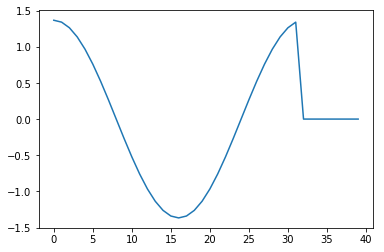

In [19]:
plt.figure()
plt.plot(cp.asnumpy(tmp[:40,0,0]))

### Find ground state


In [20]:
simparams = new_simparams(dt=-0.07/np.max([mu,Unit_Esim(10)]),N =N,L=L,eta=0,U=mu,Nt = 100,trapfunc=trapfunc,trapparams=trapparams,e = [1,0],dispersion_type = dispersion_type )#这里是化学势？
hamiltonian = new_hamiltonian(simparams)
 

In [21]:
psi = new_psi()

In [22]:
psi.init_random(simparams.grid)
# psi = new_psi(np.ones((128,128)))
psi.normalize_dens()
psi0 = psi.copy()


iter 100
wavefunction difference = 2.4937E+01


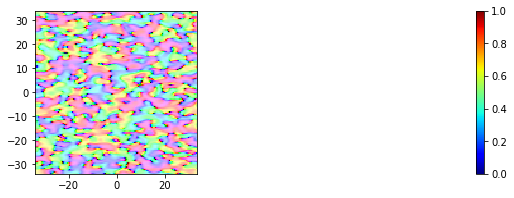

time spent = 4.6358E+00 sec
energy = -8.2624E+02
pot = -4.9691E+03
int = 1.2500E+02
kin = 4.0179E+03
gauge = -0.0000E+00
mu = -7.0124E+02


KeyboardInterrupt: 

In [23]:
threshold = 1E-6
tt=time()
grid = simparams.grid
y0,y1,x0,x1 = np.array([np.min(grid.x),np.max(grid.x),np.min(grid.y),np.max(grid.y)])*0.532 #in microns
E_old = 0
for ii in range(50000):
    psi_old = psi.copy()
    psi.value,_ = hamiltonian.evolve(psi)
    psi.normalize_dens()
    err = (1-np.abs(psi.dot(psi_old)))/dt**2

    if np.mod(ii,100)==0 or err<threshold:
        if time()-tt<2 and err >= threshold:
            continue
        print('iter ' + str(ii))
        print('wavefunction difference = %.4E' % err)
        plt.figure(figsize=(100,3))
        plt.imshow(colorize(cp.asnumpy(pool(psi.value))),cmap='jet',extent=[x0,x1,y0,y1],vmin = 0)
        plt.colorbar()
        #     plt.gca().grid()
        plt.show()
        print('time spent = %.4E sec' % (time()-tt))
        tt=time()

        energies = hamiltonian.energy(psi,comp = 1)
        keys = ['tot','pot','int','kin','gauge']
        E_tot,pot,inte,kin,gauge = [Unit_Hz(energies[key]) for key in keys]
        print('energy = %.4E' % E_tot)
        print('pot = %.4E' % pot)
        print('int = %.4E' % inte)
        print('kin = %.4E' % kin)
        print('gauge = %.4E' % gauge)
        print('mu = %.4E' % Unit_Hz(hamiltonian.chempot(psi)))
        if inte+gauge<0:
            break
        if err < threshold and np.abs(E_tot-E_old)/E_tot<1E-5:
            break
        E_old = E_tot

    if np.mod(ii,1000)==0 and err>100*threshold:
        psi.value = psi.value + 0.1*5*np.max(np.abs(psi.value))*(cp.random.rand(*psi.value.shape)+1j*cp.random.rand(*psi.value.shape))  
        psi.normalize_dens()
        

In [0]:

psi_gs = psi.copy()

psi_gs.normalize()

factor = cp.real(cp.mean(psi.value)/cp.mean(psi_gs.value)) #get normalization factor

psi_gs.normalize(factor = factor)

### Evolve

0.0009279291051898899


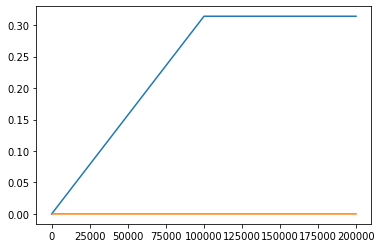

In [0]:

trapfunc = lambda x,y,t,U,k,A,w: U/2*np.cos(k*x+A(t)[0]/2*np.sin(w*t)+A(t)[1]/2*np.sin(2*w*t))

# trapfunc = lambda x,y,t,U,k,A,w: U/2*np.cos(k*x+A(t)[0]/2*np.sin(w*t)+A(t)[1]/2*np.sin(2*w*t))+0.05*U*(x**2+y**2)/Lbox**2

# trapfunc = lambda x,y,t,U,k,A,w: U/2*np.cos(k*x+A(t)[0]/2*np.sin(w*t)+A(t)[1]/2*np.sin(2*w*t))+\
# U/2*(1-np.greater(0,x**2-(Lbox/2)**2)*np.greater(0,y**2-(Lbox/2)**2))

A = lambda t: [2*np.pi*0.05*np.min([2*t/(T_all_sim*T_sim),1]),2*np.pi*0.05*0*np.min([4*t/(T_all_sim*T_sim),1])]
trapparams = [U_tr_sim,k_sim,A,w_sim]

mu_ac = -200*0
mu_ac = Unit_Esim(mu_ac)


U_tot =  mu + mu_ac*cp.cos(cp.array(w_sim*T))*cp.array([np.min([4*t/(T_all_sim*T_sim),1]) for t in T])

#print(len(U_tot))
print(dt)

plt.figure()
plt.plot([A(t) for t in T])
plt.show()

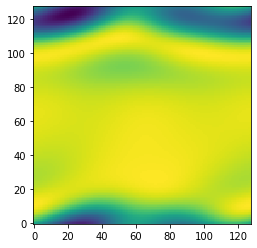

In [0]:

plt.figure()
plt.imshow(cp.asnumpy(pool(psi_gs.abs2())))

In [0]:

simparams = new_simparams(dt=-dt*(1j+0.01),N =N,L=L,eta=-eta/k0,U=U_tot,Nt = Nt,T=T,trapfunc=trapfunc,trapparams=trapparams,e = [1,0],dispersion_type = dispersion_type )
hamiltonian = new_hamiltonian(simparams)
psi = psi_gs.copy()
psi.value = psi.value + cp.array((2*(np.random.random(N)+1j*np.random.random(N))-1-1j)*0.0000*np.sqrt(np.max(np.abs(cp.asnumpy(psi.value))**2)))
psi.normalize(factor = factor)

In [0]:
def get_j(value):
  out = cp.imag(cp.conj(value)*(cp.roll(value,1,axis = 0)-value))
  return out
# plt.figure(figsize=(100,8))
# plt.imshow(cp.asnumpy(get_j(pool(psi.value))),cmap='bwr',extent=[x0,x1,y0,y1])
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(100,8))
# plt.imshow(colorize(cp.asnumpy(pool(psi.value))),extent=[x0,x1,y0,y1])
# plt.colorbar()
# plt.show()

In [0]:
threshold = 1E-8
tt=time()
grid = simparams.grid
y0,y1,x0,x1 = np.array([np.min(grid.x),np.max(grid.x),np.min(grid.y),np.max(grid.y)])*xstep*1E6 #in microns
ky0,ky1,kx0,kx1 = np.array([np.min(grid.kx),np.max(grid.kx),np.min(grid.ky),np.max(grid.ky)])/xstep/1E6 #in pi/microns
E_old = 0

psi_store = np.zeros([*(psi_gs.value.shape[:2]),int(np.ceil(Nt/output_step))],dtype = np.complex128)
pop = np.zeros(int(np.ceil(Nt/output_step)))
for nt in range(Nt):
    psi_oldvalue = psi.value.copy()
    psi.value,_ = hamiltonian.evolve(psi,nt=nt)
    psi.normalize(factor = factor)
    psi.value = psi.value + cp.random.normal(size = psi.value.shape)*0.0001*np.sqrt(np.max(psi.abs2()))
    psi.normalize(factor = factor)
    if np.mod(nt,output_step*10)==25:
        psi_store[:,:,int(nt/output_step)] = cp.asnumpy(psi.value)
        print('iter ' + str(nt))
        print('wavefunction difference = %.4E' % err)
        plt.figure(figsize=(100,8))
        plt.imshow(colorize(cp.asnumpy(pool(psi.value))),cmap='jet',extent=[x0,x1,y0,y1],vmin = 0)
        plt.colorbar()
        plt.show()
        plt.figure(figsize=(100,8))
        plt.imshow(cp.asnumpy(get_j(pool(psi.value))),cmap='bwr',extent=[x0,x1,y0,y1])
        plt.colorbar()
        plt.show()
        print('time spent = %.4E sec' % (time()-tt))
        tt=time()

        print(pop[int(nt/output_step)])

        energies = hamiltonian.energy(psi,comp = 1)
        keys = ['tot','pot','int','kin','gauge']
        E_tot,pot,inte,kin,gauge = [Unit_Hz(energies[key]) for key in keys]
        print('energy = %.4E' % E_tot)
        print('pot = %.4E' % pot)
        print('int = %.4E' % inte)
        print('kin = %.4E' % kin)
        print('gauge = %.4E' % gauge)
        print('mu = %.4E' % Unit_Hz(hamiltonian.chempot(psi)))
        E_old = E_tot

    # if np.mod(ii,1000)==0 and err>10*threshold:
    #     psi.value = psi.value + 0.1*np.max([err,1])*np.max(np.abs(psi.value))*(cp.random.rand(*psi.value.shape)+1j*cp.random.rand(*psi.value.shape))  
    #     psi.normalize()
        

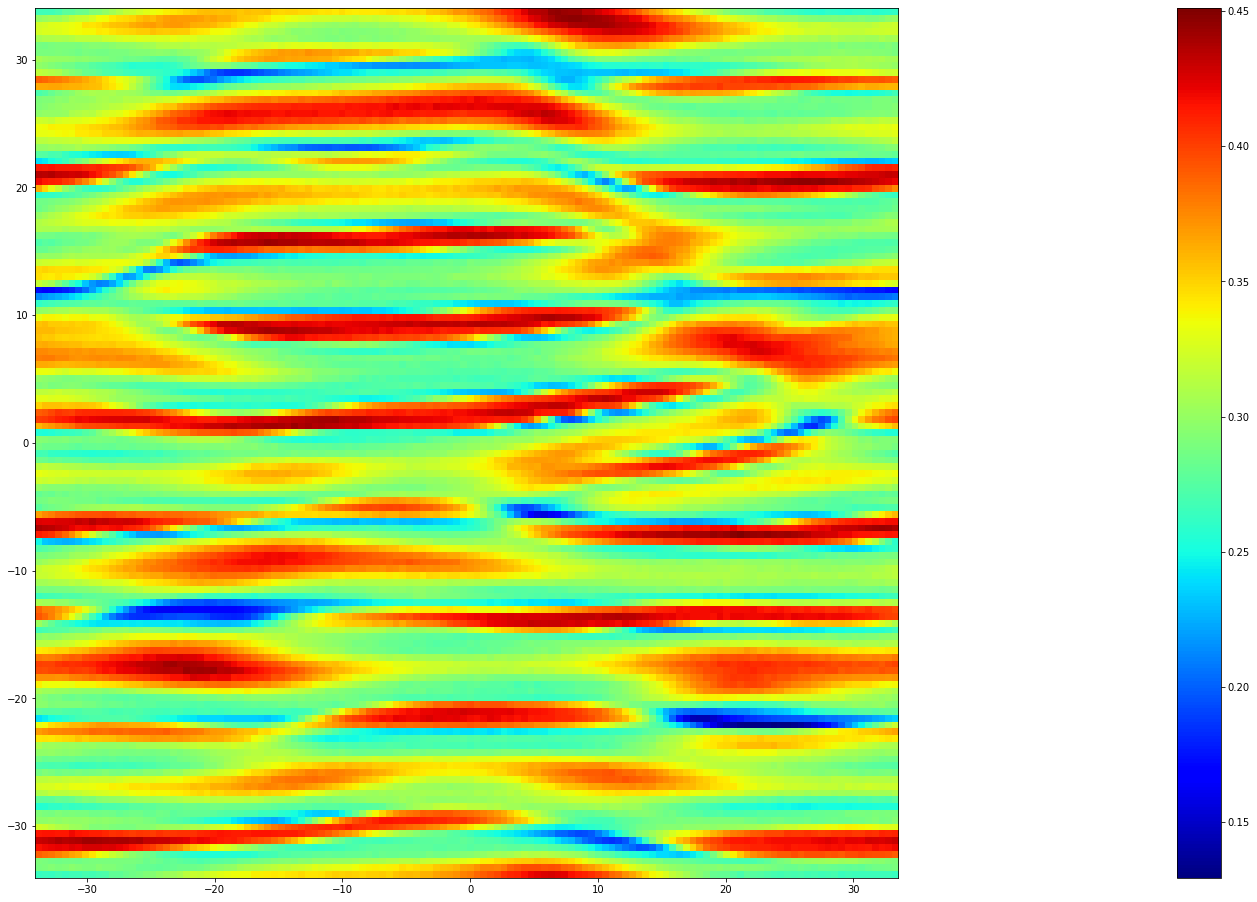

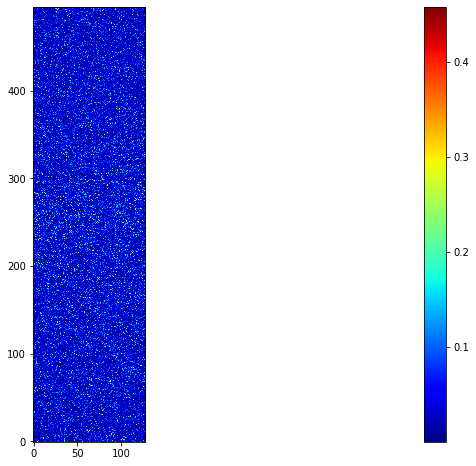

In [0]:

plt.figure(figsize=(100,16))
plt.imshow(cp.asnumpy(pool(psi.abs2())),cmap='jet',extent=[x0,x1,y0,y1])
plt.colorbar()
#     plt.gca().grid()
plt.show()
plt.figure(figsize=(100,8))
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(cp.asnumpy(psi.value))[1800:-1800]))**2,cmap='jet')#,extent=[kx0,kx1,ky0,ky1])
plt.colorbar()
#     plt.gca().grid()
plt.show()